# Anomaly Detection on UNSW-NB15 Dataset

Этот notebook демонстрирует полный цикл обнаружения аномалий в сетевом трафике на датасете UNSW-NB15.

## План работы:
1. **Загрузка и предварительный анализ данных**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering и предобработка**
4. **Обучение моделей anomaly detection**
5. **Оценка и сравнение результатов**
6. **Интерпретация и визуализация аномалий**

## 1. Настройка окружения и загрузка данных

In [15]:
import logging
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

# ML библиотеки
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Настройки визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
#%matplotlib inline

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Настройки
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

print("✓ Библиотеки загружены успешно")

✓ Библиотеки загружены успешно


In [16]:
# Загрузка конфигурации
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Конфигурация загружена:")
print(f"- Модели: {list(config['models'].keys())}")
print(f"- Группы признаков: {list(config['features'].keys())}")
print(f"- Пути: {list(config['paths'].keys())}")

Конфигурация загружена:
- Модели: ['isolation_forest', 'lof', 'one_class_svm']
- Группы признаков: ['network_basic', 'transport', 'statistical', 'contextual', 'additional', 'categorical', 'exclude']
- Пути: ['artifacts_dir', 'logs_dir', 'models_dir', 'reports_dir', 'eda_dir']


In [17]:
# Загрузка данных UNSW-NB15

try:
    train_data = pd.read_csv('../data/UNSW_NB15_training-set.csv')
    test_data = pd.read_csv('../data/UNSW_NB15_testing-set.csv')
    print(f"✓ Данные загружены:")
    print(f"  - Train: {train_data.shape}")
    print(f"  - Test: {test_data.shape}")
except FileNotFoundError:
    print("❌ Файлы данных не найдены!")
    print("Скачайте UNSW-NB15 dataset и поместите CSV файлы в папку data/")
    print("Альтернативно: используйте команду CLI для загрузки")

    # Создаем пример данных для демонстрации
    print("\n🔄 Создаем демо-данные для тестирования...")
    np.random.seed(42)
    n_samples = 1000

    # Генерируем синтетические данные, похожие на UNSW-NB15
    demo_data = {
        'dur': np.random.exponential(0.1, n_samples),
        'sbytes': np.random.lognormal(8, 2, n_samples),
        'dbytes': np.random.lognormal(7, 2, n_samples),
        'sttl': np.random.choice([64, 128, 255], n_samples),
        'dttl': np.random.choice([64, 128, 255], n_samples),
        'spkts': np.random.poisson(50, n_samples),
        'dpkts': np.random.poisson(45, n_samples),
        'sload': np.random.normal(1000, 200, n_samples),
        'dload': np.random.normal(800, 150, n_samples),
        'label': np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    }

    train_data = pd.DataFrame(demo_data)
    test_data = train_data.sample(frac=0.3).copy()

    print(f"✓ Демо-данные созданы: {train_data.shape}")

✓ Данные загружены:
  - Train: (175341, 45)
  - Test: (82332, 45)


## 2. Exploratory Data Analysis (EDA)

In [18]:
# Общая информация о датасете
print("=== ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Размерность train: {train_data.shape}")
print(f"Размерность test: {test_data.shape}")
print(f"\nТипы данных:")
print(train_data.dtypes.value_counts())

# Проверка пропусков
missing_data = train_data.isnull().sum()
if missing_data.sum() > 0:
    print(f"\n⚠️ Пропуски в данных:")
    print(missing_data[missing_data > 0].sort_values(ascending=False))
else:
    print("\n✓ Пропусков в данных нет")

# Статистика по меткам (если есть)
if 'label' in train_data.columns:
    print(f"\n=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===")
    label_counts = train_data['label'].value_counts()
    print(label_counts)
    print(f"Доля аномалий: {label_counts.get(1, 0) / len(train_data) * 100:.2f}%")

=== ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Размерность train: (175341, 45)
Размерность test: (82332, 45)

Типы данных:
int64      30
float64    11
object      4
Name: count, dtype: int64

✓ Пропусков в данных нет

=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
label
1    119341
0     56000
Name: count, dtype: int64
Доля аномалий: 68.06%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10404\3403511318.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  if train_data[feature].max() / train_data[feature].min() > 1000:


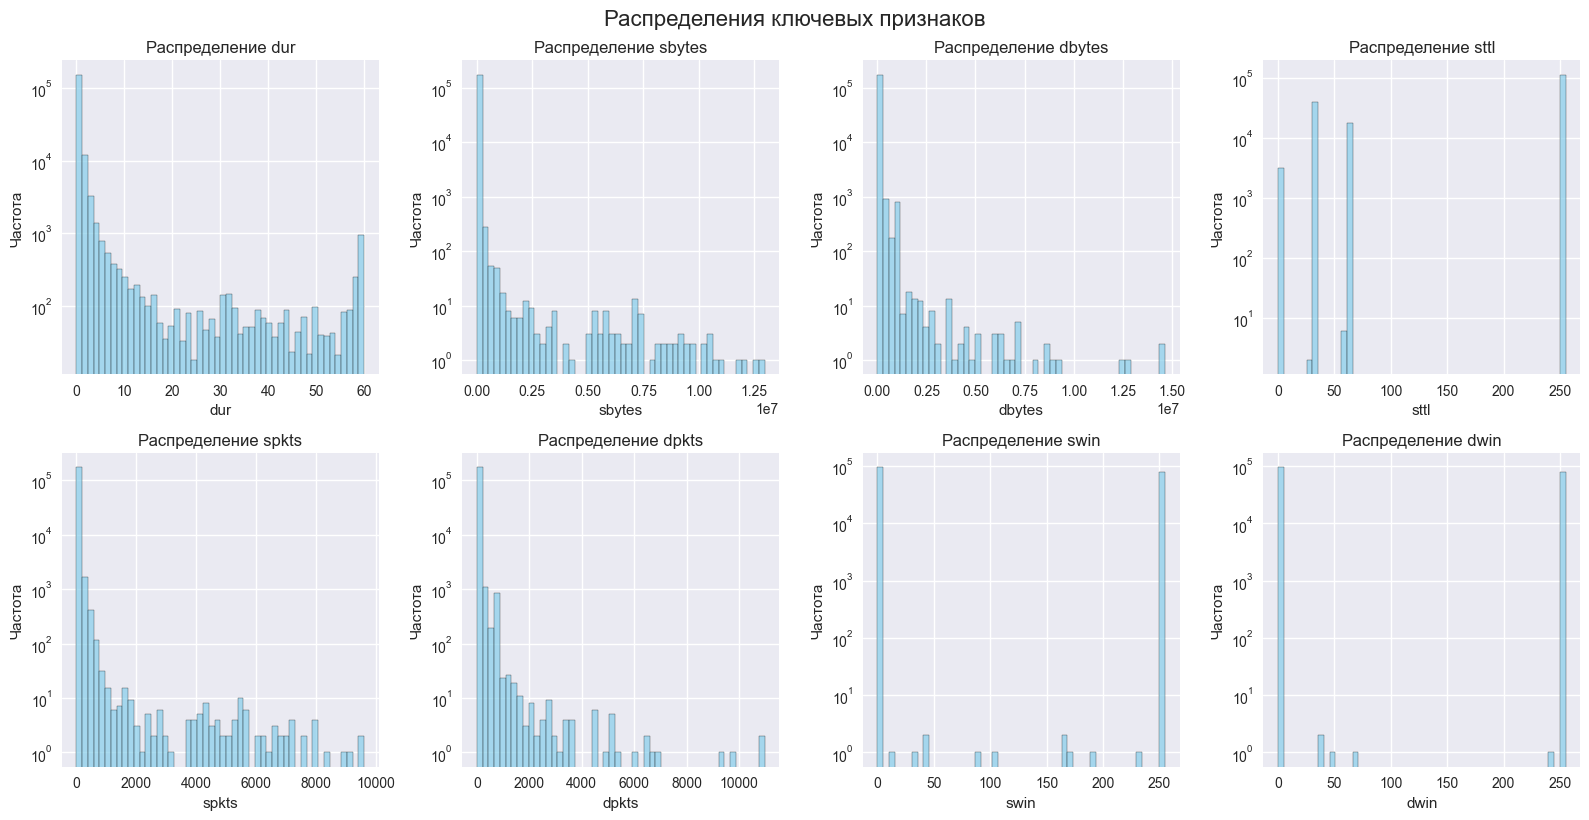

In [19]:
# Визуализация распределений ключевых признаков
# Используем признаки из конфигурации
key_features = (config['features']['network_basic'][:4] +
                config['features']['transport'][:4])

# Фильтруем только существующие признаки
existing_features = [f for f in key_features if f in train_data.columns]

if existing_features:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, feature in enumerate(existing_features):
        if i < 8:  # максимум 8 графиков
            # Гистограмма
            axes[i].hist(train_data[feature], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')

            # Логарифмическое масштабирование если нужно
            if train_data[feature].max() / train_data[feature].min() > 1000:
                axes[i].set_yscale('log')

    # Скрываем лишние subplot'ы
    for i in range(len(existing_features), 8):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Распределения ключевых признаков', y=1.02, fontsize=16)
    plt.show()
else:
    print("⚠️ Ключевые признаки не найдены в данных")

⚠️ Найдены высокие корреляции (>0.8):
  spkts ↔ sbytes: 0.964
  spkts ↔ sloss: 0.971
  dpkts ↔ dbytes: 0.972
  dpkts ↔ dloss: 0.979
  sbytes ↔ sloss: 0.996
  dbytes ↔ dloss: 0.997
  dttl ↔ tcprtt: 0.807
  sinpkt ↔ is_sm_ips_ports: 0.941
  swin ↔ dwin: 0.990
  tcprtt ↔ synack: 0.949


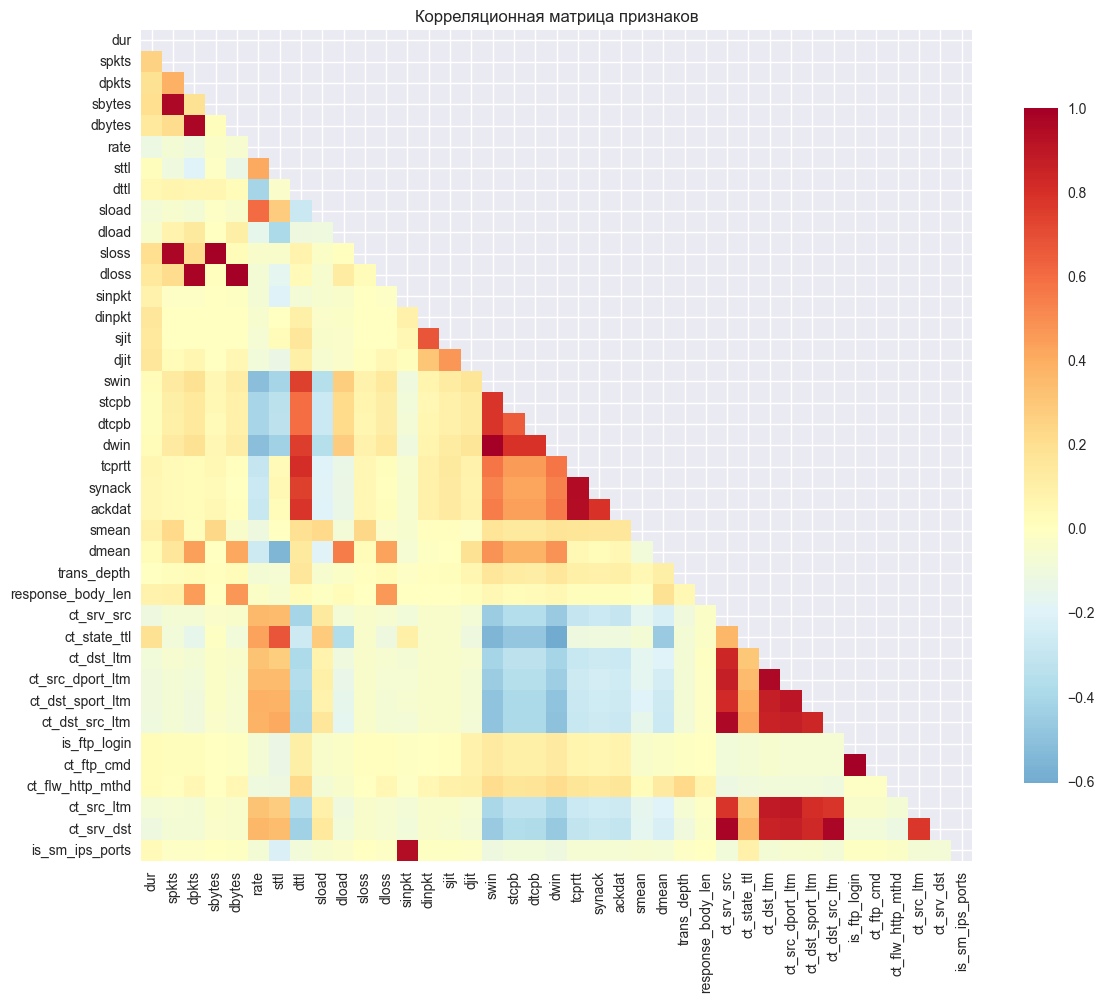

In [20]:
# Корреляционный анализ
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
# Исключаем целевую переменную из корреляционного анализа
feature_cols = [col for col in numeric_cols if col not in ['label', 'id']]

if len(feature_cols) > 1:
    correlation_matrix = train_data[feature_cols].corr()

    # Находим высокие корреляции
    threshold = config['eda']['correlation_threshold']
    high_corr = np.where((np.abs(correlation_matrix) > threshold) &
                         (correlation_matrix != 1.0))
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y],
                        correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_corr) if x < y]

    if high_corr_pairs:
        print(f"⚠️ Найдены высокие корреляции (>{threshold}):")
        for feat1, feat2, corr_val in high_corr_pairs[:10]:  # топ-10
            print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")

    # Тепловая карта корреляций
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdYlBu_r',
                center=0, square=True, cbar_kws={'shrink': 0.8})
    plt.title('Корреляционная матрица признаков')
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering и предобработка

In [21]:
# Подготовка признаков для обучения моделей
def prepare_features(data, config):
    """Подготовка признаков для обучения модели"""

    # Собираем все признаки кроме исключенных
    all_features = []
    for feature_group in ['network_basic', 'transport', 'statistical', 'contextual', 'additional']:
        if feature_group in config['features']:
            all_features.extend(config['features'][feature_group])

    # Выбираем только существующие признаки
    existing_features = [f for f in all_features if f in data.columns]

    # Исключаем целевую переменную и ID
    exclude_features = config['features'].get('exclude', ['id', 'label', 'attack_cat'])
    feature_columns = [f for f in existing_features if f not in exclude_features]

    print(f"Выбрано {len(feature_columns)} признаков для обучения:")
    print(feature_columns[:10], '...' if len(feature_columns) > 10 else '')

    return feature_columns


# Подготавливаем признаки
feature_columns = prepare_features(train_data, config)

# Создаем матрицы признаков
X_train = train_data[feature_columns].copy()
X_test = test_data[feature_columns].copy()

# Обработка пропусков (заполняем медианой)
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64']:
        median_val = X_train[col].median()
        X_train[col].fillna(median_val, inplace=True)
        X_test[col].fillna(median_val, inplace=True)

print(f"\n✓ Матрицы признаков подготовлены:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

# Проверяем наличие целевой переменной
if 'label' in train_data.columns:
    y_train = train_data['label']
    y_test = test_data['label'] if 'label' in test_data.columns else None
    print(f"  y_train: {y_train.shape}")
    if y_test is not None:
        print(f"  y_test: {y_test.shape}")
else:
    print("⚠️ Целевая переменная не найдена - будет использоваться unsupervised обучение")
    y_train = y_test = None

Выбрано 24 признаков для обучения:
['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'spkts', 'dpkts', 'swin', 'dwin', 'tcprtt'] ...

✓ Матрицы признаков подготовлены:
  X_train: (175341, 24)
  X_test: (82332, 24)
  y_train: (175341,)
  y_test: (82332,)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10404\1828562368.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(median_val, inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10404\1828562368.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

## 4. Обучение моделей Anomaly Detection

In [8]:
# Создание и обучение моделей
models = {}
pipelines = {}

# 1. Isolation Forest
iso_params = config['models']['isolation_forest']
iso_forest = IsolationForest(**iso_params)
iso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', iso_forest)
])

print("🌲 Обучение Isolation Forest...")
iso_pipeline.fit(X_train)
pipelines['Isolation Forest'] = iso_pipeline

# 2. Local Outlier Factor
lof_params = config['models']['lof']
lof = LocalOutlierFactor(**lof_params)
lof_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lof)
])

print("🎯 Обучение Local Outlier Factor...")
lof_pipeline.fit(X_train)
pipelines['Local Outlier Factor'] = lof_pipeline

# 3. One-Class SVM
svm_params = config['models']['one_class_svm']
oc_svm = OneClassSVM(**svm_params)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', oc_svm)
])

print("⚙️ Обучение One-Class SVM...")
svm_pipeline.fit(X_train)
pipelines['One-Class SVM'] = svm_pipeline

print("\n✅ Все модели обучены успешно!")
print(f"Обучено моделей: {list(pipelines.keys())}")

🌲 Обучение Isolation Forest...
🎯 Обучение Local Outlier Factor...
⚙️ Обучение One-Class SVM...

✅ Все модели обучены успешно!
Обучено моделей: ['Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']


## 5. Оценка и сравнение результатов

In [9]:
# Получение предсказаний от всех моделей
predictions = {}
anomaly_scores = {}

for name, pipeline in pipelines.items():
    print(f"📊 Получение предсказаний от {name}...")

    # Предсказания (-1 для аномалий, 1 для нормальных)
    pred = pipeline.predict(X_test)
    predictions[name] = (pred == 1).astype(int)  # Конвертируем в 0/1

    # Anomaly scores
    model = pipeline.named_steps['model']
    if hasattr(model, 'decision_function'):
        scores = pipeline.decision_function(X_test)
        anomaly_scores[name] = -scores  # Инвертируем для консистентности
    elif hasattr(model, 'score_samples'):
        scores = model.score_samples(pipeline.named_steps['scaler'].transform(X_test))
        anomaly_scores[name] = -scores
    else:
        anomaly_scores[name] = np.zeros(len(pred))

# Создаем DataFrame с результатами
results_df = pd.DataFrame(predictions)
scores_df = pd.DataFrame(anomaly_scores)

print(f"\n✅ Предсказания получены для {len(pipelines)} моделей")
print(f"Размер тестового набора: {len(X_test)}")

# Статистика предсказаний
print("\n=== СТАТИСТИКА АНОМАЛИЙ ====")
for name in pipelines.keys():
    n_anomalies = predictions[name].sum()
    anomaly_rate = n_anomalies / len(predictions[name]) * 100
    print(f"{name:20s}: {n_anomalies:4d} аномалий ({anomaly_rate:5.2f}%)")

📊 Получение предсказаний от Isolation Forest...
📊 Получение предсказаний от Local Outlier Factor...
📊 Получение предсказаний от One-Class SVM...

✅ Предсказания получены для 3 моделей
Размер тестового набора: 82332

=== СТАТИСТИКА АНОМАЛИЙ ====
Isolation Forest    : 71835 аномалий (87.25%)
Local Outlier Factor: 63050 аномалий (76.58%)
One-Class SVM       : 71550 аномалий (86.90%)


=== ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ ===
               Model  Precision  Recall  F1-Score  ROC-AUC
    Isolation Forest     0.5665  0.8977    0.6946   0.2903
Local Outlier Factor     0.4729  0.6577    0.5502   0.6256
       One-Class SVM     0.5690  0.8981    0.6967   0.2758


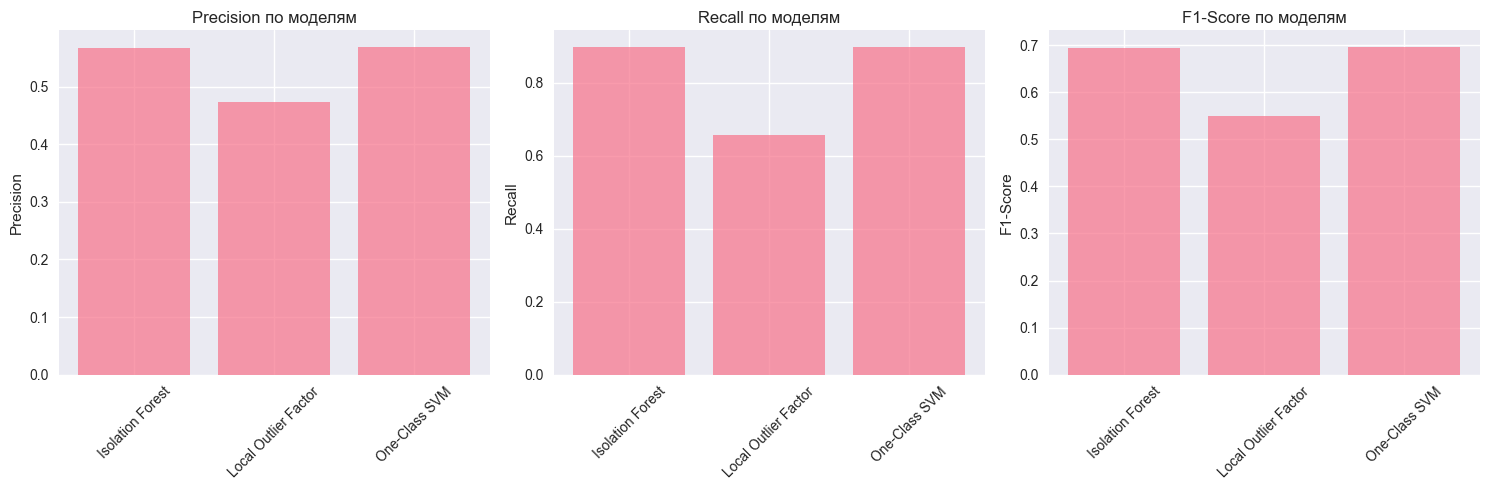

In [10]:
# Оценка моделей (если есть истинные метки)
if y_test is not None:
    print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ ===")

    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    results = []

    for name in pipelines.keys():
        y_pred = predictions[name]
        y_score = anomaly_scores[name]

        # Базовые метрики
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # ROC-AUC (если возможно)
        try:
            if len(np.unique(y_test)) > 1 and len(np.unique(y_score)) > 1:
                roc_auc = roc_auc_score(y_test, y_score)
            else:
                roc_auc = np.nan
        except:
            roc_auc = np.nan

        results.append({
            'Model': name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })

    # Создаем таблицу результатов
    results_table = pd.DataFrame(results)
    results_table = results_table.round(4)
    print(results_table.to_string(index=False))

    # Визуализация метрик
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Precision, Recall, F1
    metrics = ['Precision', 'Recall', 'F1-Score']
    for i, metric in enumerate(metrics):
        axes[i].bar(results_table['Model'], results_table[metric], alpha=0.7)
        axes[i].set_title(f'{metric} по моделям')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Истинные метки недоступны - пропускаем supervised оценку")
    print("Для полной оценки качества загрузите данные с метками классов")

## 6. Интерпретация и визуализация аномалий

=== АНАЛИЗ КОНСЕНСУСА МОДЕЛЕЙ ===
Количество моделей, считающих точку аномалией:
  0 моделей: 2657 точек ( 3.23%)
  1 моделей: 6019 точек ( 7.31%)
  2 моделей: 20552 точек (24.96%)
  3 моделей: 53104 точек (64.50%)

🎯 Единогласно признанных аномалий: 53104 (64.50%)


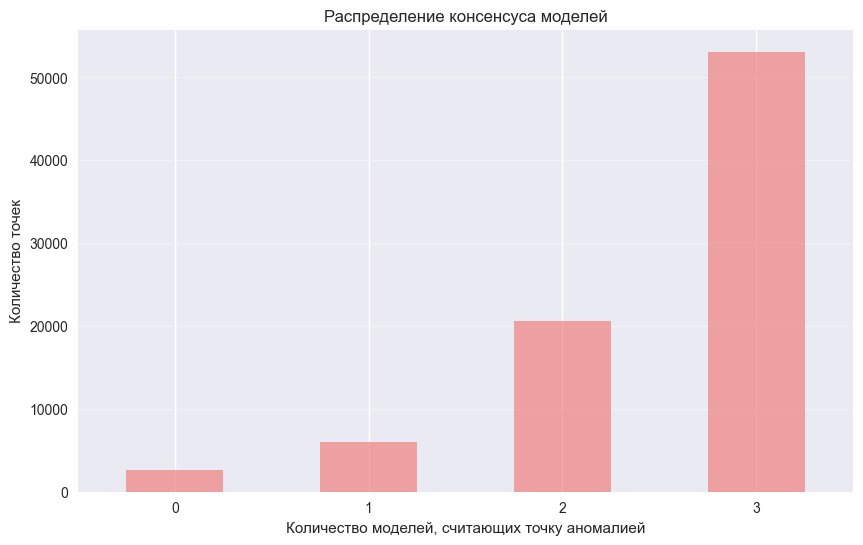

In [11]:
# Анализ консенсуса моделей
# Сколько моделей считают каждую точку аномалией?
consensus_scores = results_df.sum(axis=1)

print("=== АНАЛИЗ КОНСЕНСУСА МОДЕЛЕЙ ===")
consensus_counts = consensus_scores.value_counts().sort_index()
print("Количество моделей, считающих точку аномалией:")
for score, count in consensus_counts.items():
    percentage = count / len(consensus_scores) * 100
    print(f"  {score} моделей: {count:4d} точек ({percentage:5.2f}%)")

# Точки, которые все модели считают аномальными
unanimous_anomalies = consensus_scores == len(pipelines)
n_unanimous = unanimous_anomalies.sum()
print(f"\n🎯 Единогласно признанных аномалий: {n_unanimous} ({n_unanimous / len(consensus_scores) * 100:.2f}%)")

# Визуализация консенсуса
plt.figure(figsize=(10, 6))
consensus_counts.plot(kind='bar', alpha=0.7, color='lightcoral')
plt.title('Распределение консенсуса моделей')
plt.xlabel('Количество моделей, считающих точку аномалией')
plt.ylabel('Количество точек')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

🔍 Создание PCA визуализации аномалий...
Объясненная дисперсия PCA: 0.399


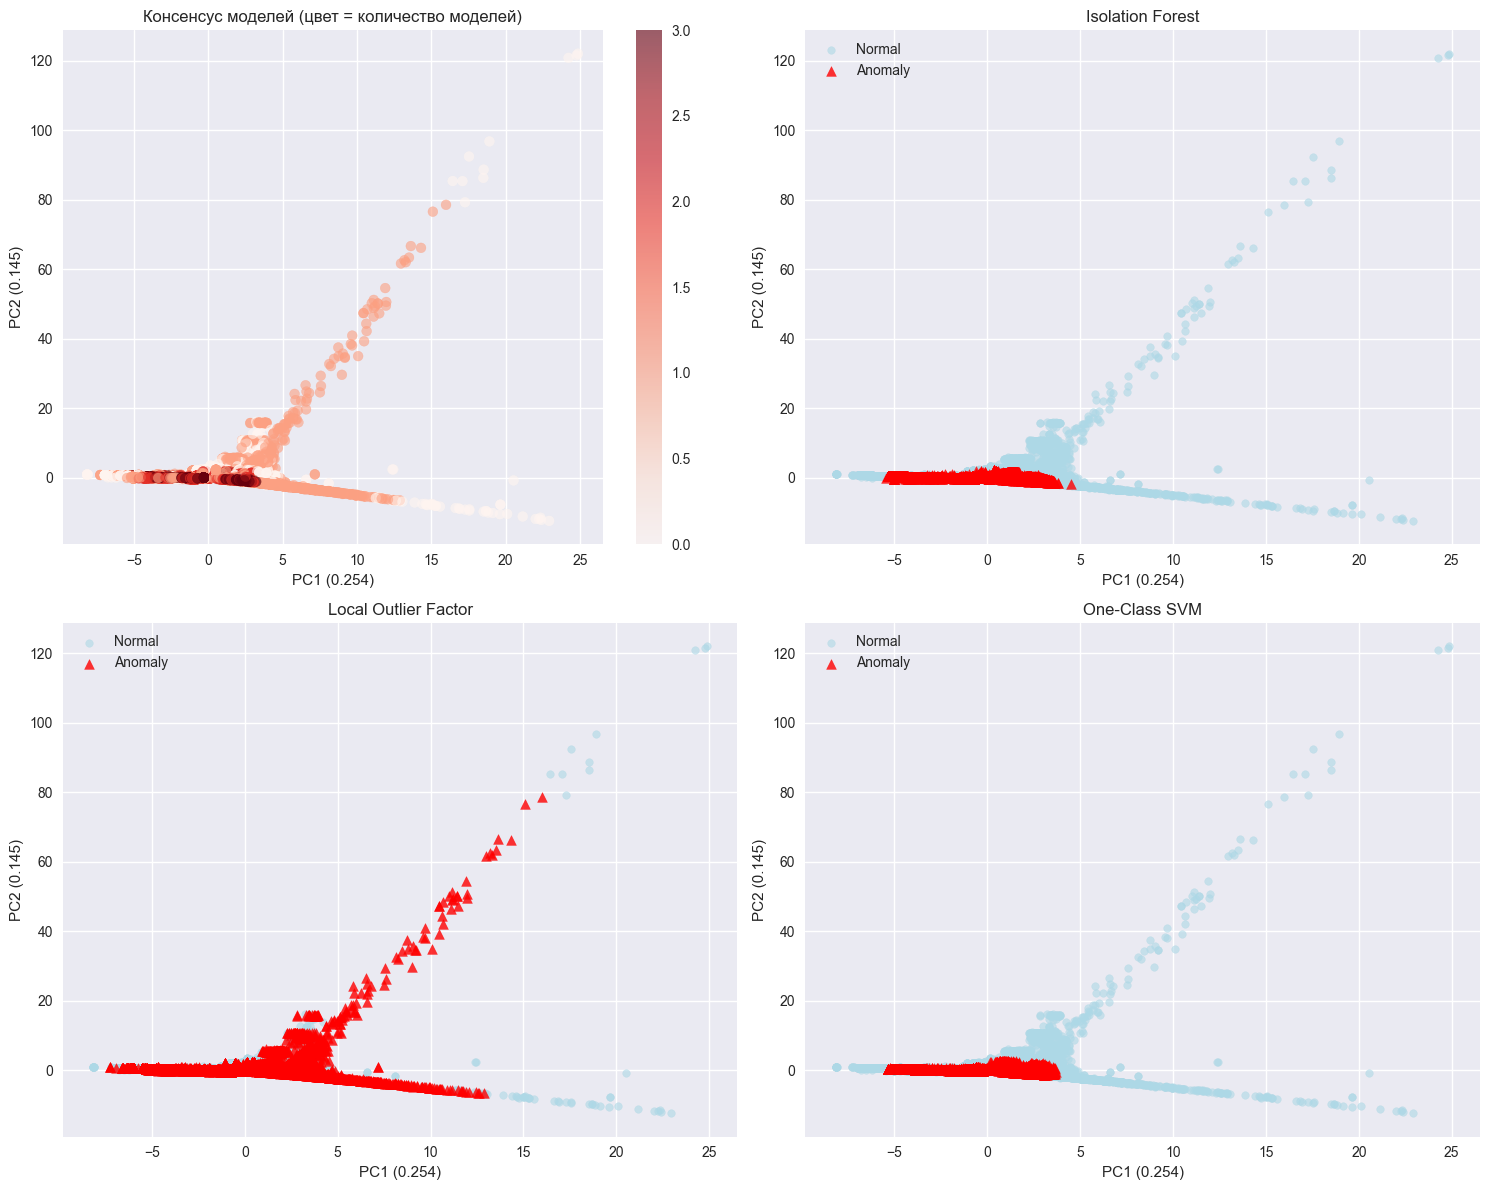

In [12]:
# PCA визуализация аномалий
print("🔍 Создание PCA визуализации аномалий...")

# Применяем PCA для снижения размерности
pca = PCA(n_components=2, random_state=42)
X_test_scaled = StandardScaler().fit_transform(X_test)
X_pca = pca.fit_transform(X_test_scaled)

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.3f}")

# Создаем визуализацию для каждой модели
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Общий plot с консенсусом
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=consensus_scores, cmap='Reds',
                          alpha=0.6, s=50)
axes[0].set_title('Консенсус моделей (цвет = количество моделей)')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.colorbar(scatter, ax=axes[0])

# Отдельные plots для каждой модели
colors = ['normal', 'anomaly']
color_map = {0: 'lightblue', 1: 'red'}

for i, (name, pred) in enumerate(predictions.items()):
    if i < 3:  # максимум 3 модели
        ax = axes[i + 1]

        # Нормальные точки
        normal_mask = pred == 0
        ax.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1],
                   c='lightblue', alpha=0.6, s=30, label='Normal')

        # Аномальные точки
        anomaly_mask = pred == 1
        ax.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1],
                   c='red', alpha=0.8, s=50, label='Anomaly', marker='^')

        ax.set_title(f'{name}')
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
        ax.legend()

plt.tight_layout()
plt.show()

# Скрываем последний subplot если не используется
if len(pipelines) < 3:
    axes[-1].set_visible(False)

In [13]:
# Анализ топ-аномалий
print("🔥 Анализ наиболее аномальных точек")

# Выберем модель с лучшими результатами (или Isolation Forest по умолчанию)
best_model_name = 'Isolation Forest'  # Можно поменять на основе результатов оценки
best_scores = anomaly_scores[best_model_name]
best_predictions = predictions[best_model_name]

# Найдем топ-10 самых аномальных точек
top_anomalies_idx = np.argsort(best_scores)[-10:]
print(f"\nТоп-10 аномалий по модели {best_model_name}:")

for i, idx in enumerate(reversed(top_anomalies_idx)):
    score = best_scores[idx]
    consensus = consensus_scores.iloc[idx]
    print(f"{i + 1:2d}. Индекс {idx:4d}: score={score:.4f}, консенсус={consensus}/{len(pipelines)}")

# Показать характеристики топ-аномалий
top_anomalies_data = X_test.iloc[top_anomalies_idx]
print(f"\nХарактеристики топ-аномалий:")
print(top_anomalies_data.describe())

# Сравним с нормальными точками
normal_points_idx = np.where(best_predictions == 0)[0][:100]  # 100 случайных нормальных
normal_data = X_test.iloc[normal_points_idx]

print(f"\nСравнение средних значений (Аномалии vs Нормальные):")
comparison = pd.DataFrame({
    'Anomalies_mean': top_anomalies_data.mean(),
    'Normal_mean': normal_data.mean(),
})
comparison['Difference'] = comparison['Anomalies_mean'] - comparison['Normal_mean']
comparison['Ratio'] = comparison['Anomalies_mean'] / comparison['Normal_mean']

# Покажем признаки с наибольшими различиями
comparison_sorted = comparison.reindex(comparison['Difference'].abs().sort_values(ascending=False).index)
print(comparison_sorted.head(10).round(3))

🔥 Анализ наиболее аномальных точек

Топ-10 аномалий по модели Isolation Forest:
 1. Индекс 10154: score=0.2513, консенсус=0/3
 2. Индекс 10554: score=0.2464, консенсус=0/3
 3. Индекс 61812: score=0.2462, консенсус=0/3
 4. Индекс 49377: score=0.2461, консенсус=0/3
 5. Индекс 64563: score=0.2436, консенсус=1/3
 6. Индекс 11401: score=0.2434, консенсус=0/3
 7. Индекс 60349: score=0.2407, консенсус=0/3
 8. Индекс 9541: score=0.2382, консенсус=1/3
 9. Индекс 49634: score=0.2376, консенсус=1/3
10. Индекс 24300: score=0.2332, консенсус=0/3

Характеристики топ-аномалий:
             dur        sbytes        dbytes        sttl        dttl  \
count  10.000000  1.000000e+01  1.000000e+01   10.000000   10.000000   
mean   55.620127  4.737275e+06  5.479370e+06  116.500000  229.700000   
std    13.739913  6.131563e+06  5.672396e+06   95.365088   70.518792   
min    16.515686  3.454600e+04  4.805200e+04   31.000000   29.000000   
25%    59.948223  4.781600e+04  6.240300e+04   62.000000  252.000000   

## 7. Сохранение результатов и выводы

In [14]:
# Создаем директории для сохранения
artifacts_dir = Path('../artifacts')
models_dir = artifacts_dir / 'models'
reports_dir = artifacts_dir / 'reports'

artifacts_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)
reports_dir.mkdir(exist_ok=True)

# Сохранение моделей
print("💾 Сохранение обученных моделей...")
for name, pipeline in pipelines.items():
    model_filename = name.lower().replace(' ', '_').replace('-', '_') + '_model.joblib'
    joblib.dump(pipeline, models_dir / model_filename)
    print(f"✓ {name} сохранена как {model_filename}")

# Сохранение результатов предсказаний
results_with_data = X_test.copy()
for name in pipelines.keys():
    results_with_data[f'{name}_prediction'] = predictions[name]
    results_with_data[f'{name}_score'] = anomaly_scores[name]

results_with_data['consensus_score'] = consensus_scores
results_with_data.to_csv(reports_dir / 'predictions_detailed.csv', index=False)
print(f"✓ Детальные предсказания сохранены в predictions_detailed.csv")

# Сохранение метрик (если доступны)
if y_test is not None:
    results_table.to_csv(reports_dir / 'model_comparison.csv', index=False)
    print(f"✓ Сравнение моделей сохранено в model_comparison.csv")

print(f"\n🎉 Анализ завершен! Все результаты сохранены в {artifacts_dir}")

💾 Сохранение обученных моделей...
✓ Isolation Forest сохранена как isolation_forest_model.joblib
✓ Local Outlier Factor сохранена как local_outlier_factor_model.joblib
✓ One-Class SVM сохранена как one_class_svm_model.joblib
✓ Детальные предсказания сохранены в predictions_detailed.csv
✓ Сравнение моделей сохранено в model_comparison.csv

🎉 Анализ завершен! Все результаты сохранены в ..\artifacts


## Выводы и рекомендации

### Основные результаты:
...

### Следующие шаги:
...

### Для production:
...